In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("thesis")
from os.path import join
import seaborn as sns
from sys import path
path.insert(0,'../src/')
from glob import glob
from chemulator import Chemulator
rollig_folder="../../Benchmarking/grid_inputs/"
import matplotlib.gridspec as gridspec
from time import perf_counter
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import h5py
from snapshot_functions import get_elemental_abundances

In [8]:
#constants
XH  = 0.76                        # the hydrogen mass fraction
gama= 5.0/3.0                     # the adiabatic index
KB  = 1.3807e-16                  # the Boltzmann constant in CGS units  [cm^2 g s^-2 K^-1]
KB_kev  = 8.6173324e-8 
mp  = 1.6726e-24                  # proton mass in CGS units

UnitMass_in_g = 1.989e33
UnitLength_in_cm    = 3.085678e18
PROTONMASS=1.6726e-24
UnitDensity_in_cgs = UnitMass_in_g / UnitLength_in_cm**3
UnitDensity_in_pccm = UnitDensity_in_cgs/PROTONMASS


# Time Dependence

The Emulator Prototyping notebook shows that over a single iteration, the emulator is very accurate. However, users will want to run the emulator multiple times to simulate longer periods of time. It's important that the emulator is stable over many runs for this reason.





In [9]:
autoencoder_dir="../autoencoders/noisy_8_encoder/"
emulator=Chemulator(autoencoder_dir)
emulator.load_model("../emulators/local-uv-test/")

# Import the snapfile to read the temperature and Density

In [14]:




filename = "/Users/raouf/Work_space/projects/ParticleGridMapper.jl/CHIMES_1807/snapshots/snapshot_040.hdf5"
# chimes_abundances = "/Users/raouf/Work_space/projects/ParticleGridMapper.jl/CHIMES_1807/snapshots/..."


f = h5py.File(filename, "r")
# input_data=pd.read_hdf("../data/Small-Network-Emulator-Input.hdf",key="df").reset_index(drop=True)

elemental_abundances=get_elemental_abundances(f["PartType0"]["ChimesAbundances"])
mu  = (4.*mp)/(1.+3.*XH+4.*XH*elemental_abundances["E-"]) # mean Molecular weight


# From snapshot files
input_data=pd.DataFrame()
input_data["gas_density"]=f["PartType0"]["Density"][()] * UnitDensity_in_pccm
input_data["gas_density"].div(mu)

input_data["gas_temp"] = f['PartType0']['InternalEnergy'][()]
input_data["gas_temp"] = (gama-1)* (input_data["gas_temp"]/KB)* mu* 1e10 # K

# From CHIMES (should change to only snapfile)
input_data["coldens"]=f["PartType0"]["ChimesColumnDensity"][()]
input_data["Av"]=input_data["coldens"]*1.6e-21
input_data["radfield"]=1.0 #using Milky way ISRF
input_data["zeta"]=1.0 # I assume also CRIR is milky way

input_data["local_uv"]=input_data["radfield"]*np.exp(-3.02*input_data["Av"])
input_data["local_uv"]=np.where(input_data["local_uv"]<1e-10,1e-10,input_data["local_uv"])#put a lower limit on that


input_data["local_radfield"] = input_data["radfield"] * np.exp(-3.02 * input_data["coldens"] * 1.6e-21)
input_data["local_radfield"] = np.where(
    input_data["local_radfield"] < 1e-5, 1e-5, input_data["local_radfield"]
)

print(max(np.log10(input_data["gas_temp"])))

7.981727641538676


In [15]:
emulator.physics_labels

['gas_temp', 'gas_density', 'local_radfield', 'zeta', 'metallicity']

## Some Random Models

In [20]:
 models=[]
# start_time=0.0
# i=input_data[(input_data["coldens"]*6.289E-22>0.1) & (input_data["Time"]==start_time)].index
# i=np.random.choice(i)
# models.append(i)
# i=input_data[(input_data["coldens"]*6.289E-22>5) & (input_data["gas_temp"]<100) & (input_data["Time"]==start_time)].index
# i=np.random.choice(i)
# models.append(i)
# i=np.random.choice(input_data[(input_data["gas_temp"]>2000) & (input_data["Time"]==start_time)].index)
# models.append(i)
# i=np.random.choice(input_data[(input_data["zeta"]>1000) & (input_data["Time"]==start_time)].index)
# models.append(i)
# labels=["Av=0","High Av","High T","High $\zeta$"]

In [21]:
# temps=[]
# model_df=emulator.prepare_inputs(input_data.loc[models].reset_index(drop=True),learn_scaling=False)
# steps_til_end=int((1e6-start_time)/1000.0)-1
# pred_temp=[input_data.loc[models,"gas_temp"].values]
# for i in range(steps_til_end):
#     output=emulator.predict_multiple_timesteps(model_df,1)
#     pred_temp.append(emulator.recover_real_values(output)["gas_temp"].values)

#     model_df[output.columns[2:]]=output[output.columns[2:]]
#     model_df["gas_temp"]=output["gas_temp"]
# pred_temp=np.asarray(pred_temp)

KeyError: "None of [Index(['H', 'H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+', 'C+', 'C', 'CH', 'CH+',\n       'CH2', 'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+', 'CH4', 'O', 'CH5+', 'OH+',\n       'OH', 'H2O+', 'H2O', 'H3O+', 'MG', 'MG+', 'CO+', 'CO', 'HCO+', 'O2',\n       'O2+', 'E-'],\n      dtype='object')] are in the [columns]"

IndexError: list index out of range

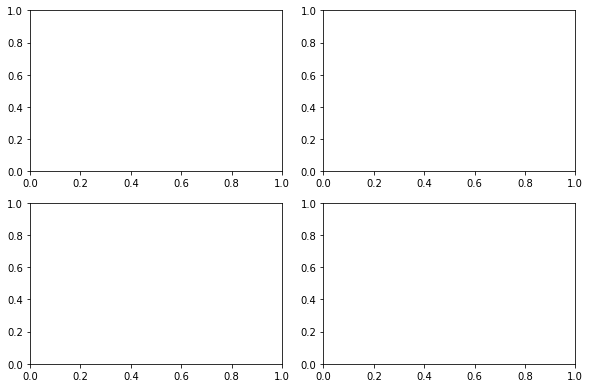

In [7]:
# fig,axes=plt.subplots(2,2,figsize=(8.3,5.5),tight_layout=True)
# axes=axes.flatten()

# for i,ax in enumerate(axes):
#     j=models[i]
#     time=input_data.loc[j:j+steps_til_end,"Time"].values
#     real_temp=input_data.loc[j:j+steps_til_end,"gas_temp"].values
#     ax.plot(time,real_temp,label="UCLCHEM",color="black")
#     ax.plot(time,pred_temp[:,i],label="Uclchemulator")
#     ax.set(xscale="log")
#     ax.legend()
#     ax.set(ylabel="Gas Temperature/ K",xlabel="Time / years")
#     ax.set(title=labels[i])
# fig.savefig("dataset_time_testing.png",dpi=300)

# Prediction Accuracy

We want to see how prediction accuracy varies with time. Get the input values at t=0 year and then predict their values at t=1000 yr, t=0.1 yr and t=1Myr

Then we can do the plots we did to compare predicted and real values for single time steps in the prototyping notebook but after that many time steps.

It's more quantitative than "here's some models".


In [22]:
test_steps=[1,100,1000]

input_data=input_data[input_data["Time"]==0.0].reset_index(drop=True)

output_data=pd.read_hdf("../data/Small-Network-Emulator-Output.hdf",key="df").reset_index(drop=True)
output_data=output_data.loc[output_data["Time"].isin(np.asarray(test_steps)*1000.0)].reset_index(drop=True)
idx=(output_data["Time"]==1e6)
full_runs=output_data.loc[idx,"outputFile"].unique()

input_data=input_data[input_data["outputFile"].isin(full_runs)].sort_values("outputFile").reset_index(drop=True)
output_data=output_data[output_data["outputFile"].isin(full_runs)].sort_values(["Time","outputFile"]).reset_index(drop=True)


output_data["dust_temp"]=output_data["dust_temp"].astype(float)



KeyError: 'Time'

In [29]:
scaled_output_data={}
reals={}
for nsteps in test_steps:
    idx=output_data["Time"]==1000.0*nsteps
    

    scaled_output_data[nsteps]=emulator.prepare_outputs(
        output_data.sort_values("outputFile").loc[idx],
        learn_scaling=False)
    real= output_data.loc[idx,["gas_temp","dust_temp"]+list(emulator.autoencoder.species)]
    real=np.where(real<1e-20,1e-20,real)
    real=np.log10(real).round(1)
    reals[nsteps]=real

input_data=emulator.prepare_inputs(input_data,learn_scaling=False)


In [30]:
mses={}
predicts={}
for nsteps in test_steps:
    print(f"starting {nsteps} steps")
    start=perf_counter()

    predict=emulator.predict_multiple_timesteps(input_data.copy(),nsteps)


    mse=(predict.values[:,0]-scaled_output_data[nsteps].values[:,0])**2.0
    mses[nsteps]=mse.mean()
    predicts[nsteps]=predict.copy()
    end=perf_counter()
    end=(end-start)/60.0
    print(f"{nsteps} steps in {end} minutes")

starting 1 steps
1 steps in 0.02074520559999655 minutes
starting 100 steps
100 steps in 2.024059337166667 minutes
starting 1000 steps
1000 steps in 23.474134560650054 minutes


In [11]:
def get_plot_df(real,pred):
    df=pd.DataFrame({"Real":real,"Predicted":pred})
    df=df.groupby("Real")["Predicted"].agg([lambda x: np.percentile(x,10),
            lambda x: np.percentile(x,50),
            lambda x: np.percentile(x,90)]).reset_index()
    df.columns=["Real","lower","median","upper"]
    return df

In [31]:
%%time
plot_df=pd.DataFrame()
plot_specs=["H","H+","H2","C","C+","CO","CH3OH","O","CH+","H2O","CO2","E-"]
plots=[0,1]+[i+2 for i in range(len(emulator.autoencoder.species)) if emulator.autoencoder.species[i] in plot_specs]
labels=["$log(T_g / K )$","$log(T_d / K )$"]+[f"log X({emulator.autoencoder.species[i-2]})"  for i in plots[2:] ]
    
for nsteps in [1000,100,1]:
    predict=emulator.recover_real_values(predicts[nsteps])
    predict=np.log10(predict).round(1)
    for i,idx in enumerate(plots):
        df=get_plot_df(reals[nsteps][:,idx],predict.values[:,idx])
        df["Quantity"]=labels[i]
        df["Nsteps"]=nsteps
        plot_df=plot_df.append(df)

CPU times: user 9.94 s, sys: 446 ms, total: 10.4 s
Wall time: 7.82 s


$log(T_g / K )$ 0
$log(T_g / K )$ 0
$log(T_g / K )$ 0


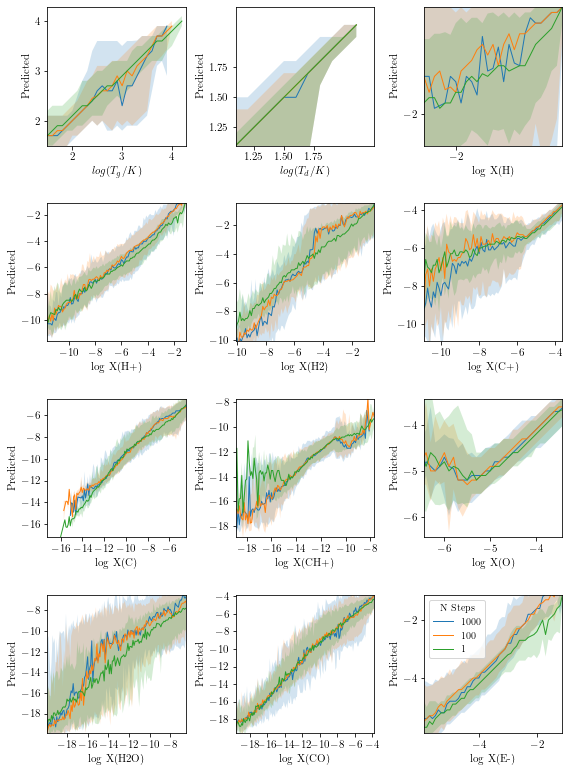

In [32]:
fig,axes=plt.subplots(4,3,figsize=(8,11),tight_layout=True)
axes=axes.flatten()
colors=sns.color_palette()
for j,nsteps in enumerate(plot_df["Nsteps"].unique()):
    idx=(plot_df["Nsteps"]==nsteps)
    color=colors[j]
    for i,label in enumerate(labels):
        idx2=idx & (plot_df["Quantity"]==label)
        axes[i].fill_between(plot_df.loc[idx2,"Real"],plot_df.loc[idx2,"lower"],plot_df.loc[idx2,"upper"],alpha=0.2)
        axes[i].plot(plot_df.loc[idx2,"Real"],plot_df.loc[idx2,"median"],color=color,label=f"{nsteps}")
        axes[i].set(xlabel=labels[i],ylabel="Predicted",aspect="equal")
        
        if i==0:
            print(label,i)
            axes[i].set(xticks=[1,2,3,4],yticks=[1,2,3,4])
        elif i==1:
            axes[i].set(xticks=np.arange(1,2,0.25),yticks=np.arange(1,2,0.25))
        elif i==8:
            axes[i].set(xticks=[-8,-7,-6,-5,-4,],yticks=[-8,-7,-6,-5,-4,])
        else:
            axes[i].set(xticks=np.arange(-18,0,2),yticks=np.arange(-18,0,2))
        axes[i].set(xlim=(plot_df.loc[idx2,"median"].min(),1.07*plot_df.loc[idx2,"median"].max()),
           ylim=(plot_df.loc[idx2,"median"].min(),1.07*plot_df.loc[idx2,"median"].max()))
axes[-1].legend(title="N Steps")


In [14]:
fig.savefig("../../Paper/80_error_over_time.pdf",type="PDF")

<ipython-input-14-b50f73c3c7f0>:1: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("../../Paper/80_error_over_time.pdf",type="PDF")


# Error by Density/Fuv

In [15]:
input_data

,gas_temp,gas_density,local_radfield,zeta,metallicity,Chem_1,Chem_2,Chem_3,Chem_4,Chem_5,Chem_6,Chem_7,Chem_8
0,0.455944,0.230221,0.000000,0.107411,0.595159,0.996677,0.402851,0.000000,0.109382,0.510081,0.092782,0.007007,0.000000
1,0.457997,0.371536,0.594919,0.365937,0.358836,0.095872,0.042026,0.082784,0.018923,0.446812,0.001684,0.821747,0.004550
2,0.251091,0.431041,0.529872,0.626363,0.071607,0.160930,0.057245,0.088123,0.020241,0.418845,0.002689,0.834862,0.000869
3,0.200375,0.076106,0.559142,0.164716,0.806981,0.018975,0.021669,0.074606,0.016998,0.490161,0.000423,0.800710,0.011007
4,0.480283,0.702570,0.434564,0.503650,0.139414,0.144987,0.053529,0.086858,0.019924,0.425452,0.002446,0.831791,0.001705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19955,0.249866,0.279828,0.000000,0.402640,0.425442,0.996108,0.402266,0.000000,0.107209,0.526588,0.092679,0.037271,0.000000
19956,0.885801,0.875786,0.000000,0.283928,0.965196,0.004608,0.015746,0.071776,0.016358,0.505314,0.000150,0.793112,0.013481
19957,0.614646,0.406441,0.857475,0.810781,0.241023,0.121682,0.048097,0.084966,0.019456,0.435349,0.002087,0.827161,0.002996
19958,0.767474,0.821880,0.561915,0.651265,0.238123,0.122336,0.048250,0.085020,0.019469,0.435066,0.002097,0.827293,0.002958


In [16]:
plot_df=input_data[["gas_density","radfield"]].merge(emulator.recover_real_values(predicts[nsteps])["gas_temp"],
                                             left_index=True,right_index=True)
plot_df["real_temp"]=10.0**reals[nsteps][:,0]
plot_df["fractional_error"]=np.sqrt((plot_df["gas_temp"]-plot_df["real_temp"]).pow(2))/plot_df["real_temp"]

KeyError: "['radfield'] not in index"

In [ ]:
def get_mesh(plot_grid,var1,var2,values):
    pivot=plot_grid.groupby([var1,var2])[values].mean().reset_index()
#     for var in [var1,var2]:
#         pivot=pivot[pivot[var]>0.9*positive[var].min()]
#         pivot=pivot[pivot[var]<1.1*positive[var].max()]


    pivot=pivot.pivot(index=var1,columns=var2,values=values)
    c = np.array(pivot.columns)
    x=np.append(c,c[-1]+np.diff(c).mean())
    r = np.array(pivot.index)
    y=np.append(r,r[-1]+np.diff(r).mean())
    X,Y = np.meshgrid(x,y)
    return X,Y,pivot.values

In [ ]:
x,y,z=get_mesh(plot_df.round(1),"gas_density","radfield","fractional_error")

In [ ]:
min_val=emulator.input_scaling_summary.loc["gas_density"]["min"]
max_val=emulator.input_scaling_summary.loc["gas_density"]["max"]
x=10.0**(x*(max_val-min_val)+min_val)

min_val=emulator.input_scaling_summary.loc["radfield"]["min"]
max_val=emulator.input_scaling_summary.loc["radfield"]["max"]
y=10.0**(y*(max_val-min_val)+min_val)


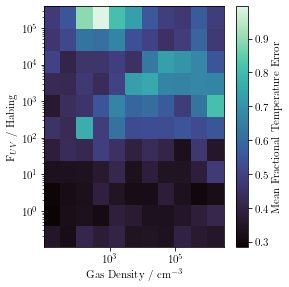

In [ ]:
fig,ax=plt.subplots(figsize=(4.1,4.1),tight_layout=True)
pc = ax.pcolormesh(x,y,z,edgecolor="face",cmap=sns.color_palette("mako",as_cmap=True))    
ax.set(xlabel="Gas Density / cm$^{-3}$",ylabel="F$_{UV}$ / Habing",xscale="log",yscale="log")
fig.colorbar(pc,label="Mean Fractional Temperature Error")

In [ ]:
fig.savefig("../../Paper/temperature_error_dist.pdf",type="PDF")

In [ ]:
sns.heatmap(data=plot_df.pivot(index="gas_density",columns="radfield",values="fractional_error"))

RuntimeError: latex was not able to process the following string:
b'gas_density'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/jon/.cache/matplotlib/tex.cache/f70bb47e060f80f818b5530cd542c01d.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file f70bb47e060f80f818b5530cd542c01d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...tsize{11.000000}{13.750000}{\rmfamily gas_
                                                  density}
No pages of output.
Transcript written on f70bb47e060f80f818b5530cd542c01d.log.




<Figure size 432x288 with 2 Axes>

# Rollig Benchmarks

The real time dependent test people will want to see is to run the Rollig Benchmarks that we compared UCLCHEM to UCLPDR using.

In [33]:
def prep_rollig(model):
    model_df=pd.read_csv(join(rollig_folder,model))
    model_df["zeta"]=3.84
    if model=="high_cr.csv":
        model_df["zeta"]=123
    #model_df["metallicity"]=1.0
    model_df["local_radfield"] = 1.7*model_df["FUV"] * np.exp(-3.02 * model_df["total_col_dens"] * 1.6e-21)
    model_df["local_radfield"]=np.where(model_df["local_radfield"]<1e-5,1e-5,model_df["local_radfield"])

    model_df=model_df[['T_g', 'n_H',"local_radfield","zeta"]]
    model_df.columns=['gas_temp','gas_density','local_radfield','zeta']


    for spec in emulator.autoencoder.species:
        model_df[spec]=0.0

    initial_abunds={
        "H":0.4,
        "H2":0.3,
        "HE":0.1,
        "C+":1.0e-4,
        "O":3.0e-4,
        "MG":5.00e-06,
        "E-":1.0e-4
    }

    for spec,abund in initial_abunds.items():
        model_df[spec]=abund
    model_df=emulator.prepare_inputs(model_df,learn_scaling=False)
    model_df[model_df<0]=0.0
    return model_df

In [34]:
%%time
models=["low_rad.csv","high_cr.csv","10_1e3.csv","10_1e5.5.csv","1e5_1e3.csv","1e5_1e5.5.csv"]
labels=[r'$F_{UV}$ 1 $n_H 10^3 cm^{-3}$',
        r'$F_{UV}$ 1 $n_H 10^3 cm^{-3}, \zeta$ 100',
        r'$F_{UV} 10 n_H 10^3 cm^{-3}$',
        r'$F_{UV} 10 n_H 10^{5.5} cm^{-3}$',
        r'$F_{UV 10^5 n_H 10^3 cm^{-3}$',
        r'$F_{UV} 10^5 n_H 10^{5.5} cm^{-3}$']


plot_df=pd.DataFrame()
for m,model in enumerate(models):
    model_df=prep_rollig(model)
    
    output=emulator.predict_multiple_timesteps(model_df,2000)
    output=emulator.recover_real_values(output)

    uclchem=join(rollig_folder,"../uclpdr/",model).replace(".csv","_output.csv")
    uclchem=pd.read_csv(uclchem)
    idx=uclchem["Particle"].isin((pd.read_csv(join(rollig_folder,model)))["Particle"])
    uclchem=uclchem.loc[idx].reset_index(drop=True)
    av=uclchem["Av"]
    output["Av"]=av
    output.to_csv(f"../../Benchmarking/emulator/{model}.csv",index=False)
    real_temp=uclchem["T_g"]
    pred_temp=output["gas_temp"]
    uv=model.split('_')[0].replace("1e","10^")
    label=f"F_{{uv}} {uv}, n_H {model.split('_')[1][:-4]}"
    
    model_df=pd.DataFrame({"Av":av,"Real Temp":real_temp,"Predicted":pred_temp})
    model_df["Model"]=label
    
    plot_df=plot_df.append(model_df,sort=False)
  

CPU times: user 2min 51s, sys: 5.61 s, total: 2min 56s
Wall time: 2min 24s


In [35]:
labels=[r'$F_{UV}$ 1 $n_H 10^3 cm^{-3}$',
        r'$F_{UV}$ 1 $n_H 10^3 cm^{-3}, \zeta$ 100',
        r'$F_{UV} 10 n_H 10^3 cm^{-3}$',
        r'$F_{UV} 10 n_H 10^{5.5} cm^{-3}$',
        r'$F_{UV} 10^5 n_H 10^3 cm^{-3}$',
        r'$F_{UV} 10^5 n_H 10^{5.5} cm^{-3}$']

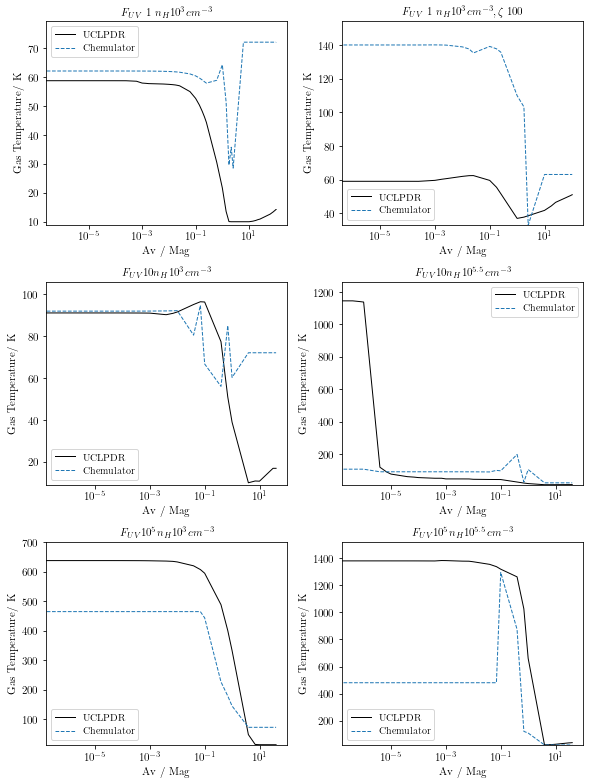

In [36]:
fig,axes=plt.subplots(3,2,figsize=(8.3,11),tight_layout=True)
axes=axes.flatten()

for i,model in enumerate(plot_df.Model.unique()):
    idx=plot_df["Model"]==model
    
    label=f"F_{{uv}} {uv}, n_H {model.split('_')[1][:-4]}"

    
    axes[i].plot(plot_df.loc[idx,"Av"],plot_df.loc[idx,"Real Temp"],label="UCLPDR",color="black")
    axes[i].plot(plot_df.loc[idx,"Av"],plot_df.loc[idx,"Predicted"],label="Chemulator",ls="--")
    axes[i].set(xscale="log")
    axes[i].legend()
    axes[i].set(ylabel="Gas Temperature/ K",xlabel="Av / Mag")
    tmax=plot_df.loc[idx,["Real Temp","Predicted"]].max().max()
    axes[i].set(ylim=(0.9*plot_df.loc[idx,"Real Temp"].min(),1.1*tmax))
    axes[i].legend()

    axes[i].set(title=labels[i])

In [ ]:
emulated.head()

,gas_temp,dust_temp,H,H+,H2,H2+,H3+,HE,HE+,C+,...,H3O+,MG,MG+,CO+,CO,HCO+,O2,O2+,E-,Av
0,50.242823,14.738799,1.0,0.000013,0.000430,6.765373e-14,3.190240e-15,0.107057,5.586305e-07,0.000075,...,7.315540e-17,8.415378e-08,0.000010,4.034282e-14,6.802436e-08,3.937465e-15,3.287298e-12,1.277238e-14,0.000099,0.000000e+00
1,50.393051,14.744650,1.0,0.000014,0.000414,7.131218e-14,3.075414e-15,0.106778,6.227359e-07,0.000077,...,6.141316e-17,8.869728e-08,0.000011,4.054603e-14,5.960385e-08,3.701441e-15,3.292976e-12,1.211498e-14,0.000103,6.240000e-07
2,50.453440,14.744785,1.0,0.000014,0.000412,7.077770e-14,3.029859e-15,0.106769,6.223695e-07,0.000077,...,6.051011e-17,8.847902e-08,0.000011,4.034212e-14,5.917167e-08,3.663999e-15,3.265914e-12,1.207914e-14,0.000103,9.920000e-07
3,50.502261,14.744463,1.0,0.000014,0.000410,7.041912e-14,2.999045e-15,0.106765,6.221741e-07,0.000077,...,5.993407e-17,8.832256e-08,0.000011,4.019771e-14,5.888262e-08,3.637671e-15,3.247021e-12,1.206141e-14,0.000103,1.376000e-06
4,50.531708,14.744329,1.0,0.000014,0.000409,7.020358e-14,2.977699e-15,0.106758,6.223463e-07,0.000077,...,5.941071e-17,8.821556e-08,0.000011,4.008726e-14,5.872289e-08,3.618391e-15,3.231834e-12,1.203342e-14,0.000103,1.760000e-06


In [ ]:
fig.savefig("../../Paper/emulator-rollig.pdf",dpi=300)

In [ ]:
../../Benchmarking/uclpdr/low_rad.csv_output.csv'

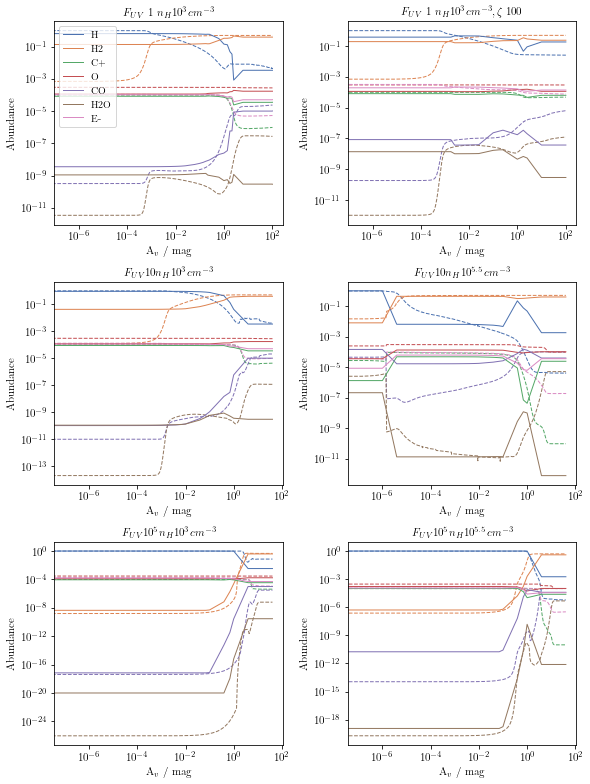

In [ ]:
["H","H2","C+","O","CO","H2O","E-"]
fig,axes=plt.subplots(3,2,figsize=(8.3,11),tight_layout=True)
axes=axes.flatten()
colors=sns.color_palette("deep",n_colors=7)

models=["low_rad.csv","high_cr.csv","10_1e3.csv","10_1e5.5.csv","1e5_1e3.csv","1e5_1e5.5.csv"]
labels=[r'$F_{UV}$ 1 $n_H 10^3 cm^{-3}$',
        r'$F_{UV}$ 1 $n_H 10^3 cm^{-3}, \zeta$ 100',
        r'$F_{UV} 10 n_H 10^3 cm^{-3}$',
        r'$F_{UV} 10 n_H 10^{5.5} cm^{-3}$',
        r'$F_{UV} 10^5 n_H 10^3 cm^{-3}$',
        r'$F_{UV} 10^5 n_H 10^{5.5} cm^{-3}$']

for k,model in enumerate(models):
    axis=axes[k]

    uclpdr=pd.read_csv(f"../../Benchmarking/uclpdr/{model}".replace(".csv","_output.csv"))
    emulated=pd.read_csv(f"../../Benchmarking/emulator/{model}.csv")
   
    uclpdr_species=["H_abun","H2_abun","C+_abun","O_abun","CO_abun","H2O_abun","e-_abun"]

    for i,col in enumerate(uclpdr_species):
        axis.plot(uclpdr["Av"],uclpdr[col],color=colors[i],ls="--",label="")

    uclchem_species=["H","H2","C+","O","CO","H2O","E-"]
    for i,col in enumerate(uclchem_species):
        axis.plot(emulated["Av"],emulated[col],color=colors[i],label=col)

    axis.set(xscale='log',yscale='log',xlabel="A$_v$ / mag",ylabel="Abundance")
    axis.legend(loc=2)
    if k!=0:
        axis.legend().remove()
    axes[k].set(title=labels[k])

In [ ]:
fig.savefig("../../Paper/emulator-rollig-chemistry.pdf",dpi=300)

In [ ]:
model="sine.csv"
model_df=prep_rollig(model)
    
output=emulator.predict_multiple_timesteps(model_df,2000)
output=emulator.recover_real_values(output)

../src/chemulator.py:124: RuntimeWarning: divide by zero encountered in log10
  inputs=np.log10(input_data[self.physics_labels].reset_index(drop=True))


In [ ]:
uclpdr=join(rollig_folder,"../uclpdr/",model).replace(".csv","_output.csv")
uclpdr=pd.read_csv(uclpdr)
idx=uclpdr["Particle"].isin((pd.read_csv(join(rollig_folder,model)))["Particle"])
uclpdr=uclpdr.loc[idx].reset_index(drop=True)

[None, Text(0, 0.5, 'Abundance'), None, Text(0.5, 0, '$A_v$ / Mag')]

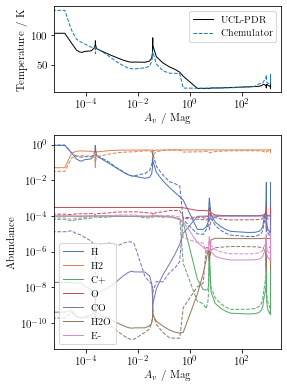

In [ ]:
fig = plt.figure(tight_layout=True,figsize=(4.1,5.5))

gs = gridspec.GridSpec(3, 1)

ax = fig.add_subplot(gs[0, 0])

ax.plot(uclpdr["Av"],uclpdr["T_g"],color="black",label="UCL-PDR")
ax.plot(uclpdr["Av"],output["gas_temp"],ls="--",label="Chemulator")
ax.set(xscale="log",xlabel="$A_v$ / Mag", ylabel="Temperature / K")
ax.legend()
ax2 = fig.add_subplot(gs[1:,0])

colors=sns.color_palette("deep",n_colors=7)
for i,species in enumerate(["H","H2","C+","O","CO","H2O","E-"]):
    if species=="E-":
        ax2.plot(uclpdr["Av"],uclpdr[f"e-_abun"],color=colors[i],label=species)
    else:
        ax2.plot(uclpdr["Av"],uclpdr[f"{species}_abun"],color=colors[i],label=species)
    ax2.plot(uclpdr["Av"],output[f"{species}"],ls="--",color=colors[i])
ax2.legend()
ax2.set(xscale="log",yscale="log",xlabel="$A_v$ / Mag", ylabel="Abundance")

In [ ]:
fig.savefig("../../Paper/emulator-sine.pdf",type="PDF")